# 4.3 树模型训练 + OOS评估（可调参）

本 notebook 使用两类树模型进行训练与调参：
- RandomForestClassifier
- GradientBoostingClassifier

流程：
1. 读取 train / OOS 数据
2. 统一预处理（删列、数值列、缺失填充）
3. TimeSeriesSplit + GridSearchCV 搜索最优参数
4. 最优模型在 OOS 上评估并导出结果

In [1]:
# ========== 1) 依赖 ==========
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score
from sklearn.calibration import calibration_curve

In [2]:
# ========== 2) 配置 ==========
PROJECT_ROOT = Path("..").resolve()
TRAIN_CSV = PROJECT_ROOT / "data" / "modeling" / "train_2015Q4_2022Q4.csv"
OOS_CSV = PROJECT_ROOT / "data" / "modeling" / "oos_2023Q1_2025Q4.csv"
OUT_DIR = PROJECT_ROOT / "data" / "modeling" / "tree_tuning"
OUT_DIR.mkdir(parents=True, exist_ok=True)

LABEL_COL = "eps_beat"
ID_COLS = ["ticker", "quarter", "fiscal_quarter"]
DROP_COLS = [
    "next_quarter_estimated", "next_quarter_actual",
    "url_pr", "url_qa", "source_file_pr", "source_file_qa",
    "timestamp_pr", "timestamp_qa",
    "section_raw_pr", "section_raw_qa",
    "url", "source_file", "timestamp", "section", "id",
]

N_SPLITS = 4
SCORING = "neg_log_loss"  # 或者改成 "roc_auc"，但不要混用
N_JOBS = -1

print("TRAIN_CSV:", TRAIN_CSV)
print("OOS_CSV:", OOS_CSV)
print("OUT_DIR:", OUT_DIR)
print("SCORING:", SCORING)

TRAIN_CSV: /Users/xinyuewang/Desktop/1.27/data/modeling/train_2015Q4_2022Q4.csv
OOS_CSV: /Users/xinyuewang/Desktop/1.27/data/modeling/oos_2023Q1_2025Q4.csv
OUT_DIR: /Users/xinyuewang/Desktop/1.27/data/modeling/tree_tuning
SCORING: neg_log_loss


In [3]:
# ========== 3) 工具函数 ==========
def quarter_to_idx(q):
    # 支持 2023Q1 / 2023-Q1
    s = str(q).strip().replace("-", "")
    if len(s) < 6 or "Q" not in s:
        return np.nan
    year = int(s[:4])
    qn = int(s[-1])
    return year * 4 + qn


def detect_quarter_col(df):
    if "fiscal_quarter" in df.columns:
        return "fiscal_quarter"
    if "quarter" in df.columns:
        return "quarter"
    raise KeyError("未找到 quarter/fiscal_quarter 列")


def make_Xy(df, label_col=LABEL_COL, id_cols=ID_COLS, drop_cols=DROP_COLS, feature_names=None):
    xdf = df.copy()
    xdf = xdf.drop(columns=[c for c in drop_cols if c in xdf.columns], errors="ignore")

    y = xdf[label_col].astype(int).copy()

    id_existing = [c for c in id_cols if c in xdf.columns]
    xdf = xdf.drop(columns=[label_col] + id_existing, errors="ignore")
    xdf = xdf.select_dtypes(include=[np.number])

    if feature_names is not None:
        xdf = xdf.reindex(columns=feature_names)

    return xdf, y

In [4]:
# ========== 4) 读取数据并按时间排序 ==========
train_df = pd.read_csv(TRAIN_CSV)
oos_df = pd.read_csv(OOS_CSV)

quarter_col_train = detect_quarter_col(train_df)
quarter_col_oos = detect_quarter_col(oos_df)

train_df["_qidx"] = train_df[quarter_col_train].map(quarter_to_idx)
oos_df["_qidx"] = oos_df[quarter_col_oos].map(quarter_to_idx)

train_df = train_df.sort_values(["_qidx", "ticker"]).reset_index(drop=True)
oos_df = oos_df.sort_values(["_qidx", "ticker"]).reset_index(drop=True)

X_train_df, y_train = make_Xy(train_df, feature_names=None)
feature_names = X_train_df.columns.tolist()
X_oos_df, y_oos = make_Xy(oos_df, feature_names=feature_names)

print("train shape:", X_train_df.shape)
print("oos shape:", X_oos_df.shape)
print("y_train mean:", y_train.mean())
print("y_oos mean:", y_oos.mean())

train shape: (744, 65)
oos shape: (330, 65)
y_train mean: 0.7701612903225806
y_oos mean: 0.8575757575757575


In [5]:
# ========== 5) 模型与参数网格（第一轮小网格，避免过大） ==========
rf_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="mean")),
    ("clf", RandomForestClassifier(random_state=42, n_jobs=-1)),
])

rf_grid = {
    "clf__n_estimators": [300, 500],
    "clf__max_depth": [None, 8],
    "clf__min_samples_leaf": [3, 5],
    "clf__max_features": ["sqrt", 0.8],
    "clf__class_weight": [None, "balanced"],
}

gbdt_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="mean")),
    ("clf", GradientBoostingClassifier(random_state=42)),
])

gbdt_grid = {
    "clf__n_estimators": [150, 300],
    "clf__learning_rate": [0.03, 0.05],
    "clf__max_depth": [2, 3],
    "clf__min_samples_leaf": [3, 5],
    "clf__subsample": [0.7, 1.0],
}

tscv = TimeSeriesSplit(n_splits=N_SPLITS)

print("RF combinations:", np.prod([len(v) for v in rf_grid.values()]))
print("GBDT combinations:", np.prod([len(v) for v in gbdt_grid.values()]))

RF combinations: 32
GBDT combinations: 32


In [6]:
# ========== 6) 调参搜索 ==========
rf_search = GridSearchCV(
    estimator=rf_pipe,
    param_grid=rf_grid,
    scoring=SCORING,
    cv=tscv,
    n_jobs=N_JOBS,
    verbose=1,
    refit=True,
)
rf_search.fit(X_train_df, y_train)

gbdt_search = GridSearchCV(
    estimator=gbdt_pipe,
    param_grid=gbdt_grid,
    scoring=SCORING,
    cv=tscv,
    n_jobs=N_JOBS,
    verbose=1,
    refit=True,
)
gbdt_search.fit(X_train_df, y_train)

print("RF best score:", rf_search.best_score_)
print("RF best params:", rf_search.best_params_)
print("GBDT best score:", gbdt_search.best_score_)
print("GBDT best params:", gbdt_search.best_params_)

Fitting 4 folds for each of 32 candidates, totalling 128 fits


Fitting 4 folds for each of 32 candidates, totalling 128 fits
RF best score: -0.5202479982540109
RF best params: {'clf__class_weight': None, 'clf__max_depth': 8, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 5, 'clf__n_estimators': 500}
GBDT best score: -0.5349131278112952
GBDT best params: {'clf__learning_rate': 0.03, 'clf__max_depth': 2, 'clf__min_samples_leaf': 5, 'clf__n_estimators': 150, 'clf__subsample': 1.0}


In [7]:
# ========== 7) OOS评估 ==========
best_models = {
    "rf_best": rf_search.best_estimator_,
    "gbdt_best": gbdt_search.best_estimator_,
}

metrics = []
preds = []

for model_id, model in best_models.items():
    p = model.predict_proba(X_oos_df)[:, 1]

    m = {
        "model_id": model_id,
        "n_train": int(len(y_train)),
        "n_oos": int(len(y_oos)),
        "y_train_mean": float(y_train.mean()),
        "y_oos_mean": float(y_oos.mean()),
        "logloss_oos": float(log_loss(y_oos, p)),
        "brier_oos": float(brier_score_loss(y_oos, p)),
        "auc_oos": float(roc_auc_score(y_oos, p)),
    }
    metrics.append(m)

    pred_df = oos_df[["ticker", quarter_col_oos]].copy()
    pred_df = pred_df.rename(columns={quarter_col_oos: "fiscal_quarter"})
    pred_df["model_id"] = model_id
    pred_df["p_text"] = p
    pred_df["actual"] = y_oos.values
    pred_df["is_oos"] = True
    preds.append(pred_df)

metrics_df = pd.DataFrame(metrics).sort_values("logloss_oos").reset_index(drop=True)
pred_df_all = pd.concat(preds, ignore_index=True)

display(metrics_df)
display(pred_df_all.head())

,model_id,n_train,n_oos,y_train_mean,y_oos_mean,logloss_oos,brier_oos,auc_oos
0,gbdt_best,744,330,0.770161,0.857576,0.427649,0.130375,0.590933
1,rf_best,744,330,0.770161,0.857576,0.431209,0.131127,0.573791


,ticker,fiscal_quarter,model_id,p_text,actual,is_oos
0,AAPL,2023-Q1,rf_best,0.798862,1,True
1,ADBE,2023-Q1,rf_best,0.858200,1,True
2,AMD,2023-Q1,rf_best,0.816963,1,True
3,AMZN,2023-Q1,rf_best,0.771328,1,True
4,AVGO,2023-Q1,rf_best,0.718781,1,True


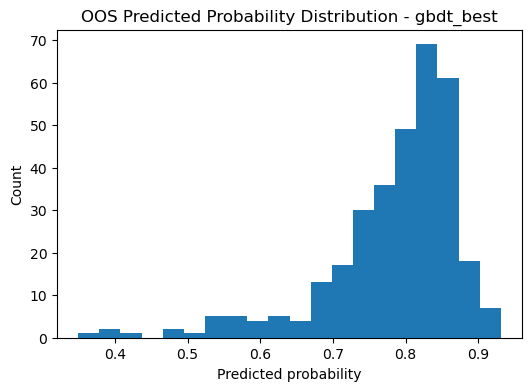

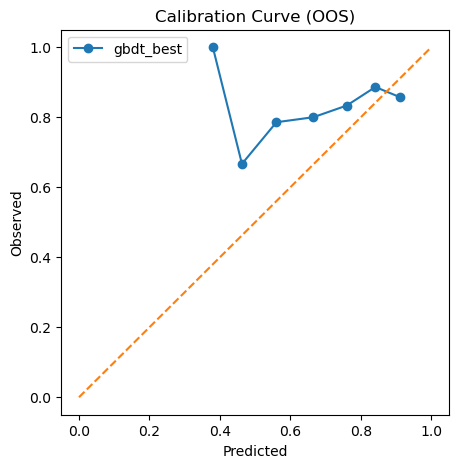

In [8]:
# ========== 8) 最优模型可视化 ==========
best_model_id = metrics_df.iloc[0]["model_id"]
best_pred = pred_df_all[pred_df_all["model_id"] == best_model_id]

plt.figure(figsize=(6, 4))
plt.hist(best_pred["p_text"], bins=20)
plt.title(f"OOS Predicted Probability Distribution - {best_model_id}")
plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.show()

prob_true, prob_pred = calibration_curve(best_pred["actual"], best_pred["p_text"], n_bins=10)
plt.figure(figsize=(5, 5))
plt.plot(prob_pred, prob_true, marker="o", label=best_model_id)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("Calibration Curve (OOS)")
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.legend()
plt.show()

In [9]:
# ========== 9) 导出（含特征重要性） ==========
metrics_df.to_csv(OUT_DIR / "tree_tuning_oos_metrics.csv", index=False)
pred_df_all.to_csv(OUT_DIR / "tree_tuning_oos_probabilities.csv", index=False)

best_params = {
    "rf_best_score": float(rf_search.best_score_),
    "rf_best_params": rf_search.best_params_,
    "gbdt_best_score": float(gbdt_search.best_score_),
    "gbdt_best_params": gbdt_search.best_params_,
    "scoring": SCORING,
    "n_splits": N_SPLITS,
}
with open(OUT_DIR / "tree_tuning_best_params.json", "w", encoding="utf-8") as f:
    json.dump(best_params, f, ensure_ascii=False, indent=2)

# 1) 提取最佳树模型特征重要性
rf_clf = rf_search.best_estimator_.named_steps["clf"]
gbdt_clf = gbdt_search.best_estimator_.named_steps["clf"]

rf_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": rf_clf.feature_importances_,
    "model": "rf_best",
}).sort_values("importance", ascending=False).reset_index(drop=True)

gbdt_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": gbdt_clf.feature_importances_,
    "model": "gbdt_best",
}).sort_values("importance", ascending=False).reset_index(drop=True)

tree_imp_all = pd.concat([rf_imp, gbdt_imp], ignore_index=True)

# 2) 保存文件（供 4.5 直接读取）
rf_imp.to_csv(OUT_DIR / "rf_feature_importance.csv", index=False)
gbdt_imp.to_csv(OUT_DIR / "gbdt_feature_importance.csv", index=False)
tree_imp_all.to_csv(OUT_DIR / "tree_feature_importance_all.csv", index=False)

# 3) 打印 Top15（对应你 4.2 的“最负向/最正向”查看习惯）
print("\n[RF] Top 15 importance:")
print(rf_imp.head(15).to_string(index=False))

print("\n[GBDT] Top 15 importance:")
print(gbdt_imp.head(15).to_string(index=False))

print("\nSaved:", OUT_DIR)
print("- tree_tuning_oos_metrics.csv")
print("- tree_tuning_oos_probabilities.csv")
print("- tree_tuning_best_params.json")
print("- rf_feature_importance.csv")
print("- gbdt_feature_importance.csv")
print("- tree_feature_importance_all.csv")


[RF] Top 15 importance:
                   feature  importance   model
lm_net_sentiment_zscore_pr    0.050209 rf_best
       lm_net_sentiment_pr    0.043446 rf_best
            lm_positive_pr    0.037433 rf_best
            lm_polarity_pr    0.035139 rf_best
            flesch_ease_pr    0.027876 rf_best
          lm_modal_weak_pr    0.024951 rf_best
           coleman_liau_pr    0.024903 rf_best
            lm_negative_pr    0.023383 rf_best
   pronoun_plural_ratio_pr    0.021468 rf_best
lm_net_sentiment_zscore_qa    0.020655 rf_best
 lm_subjectivity_zscore_qa    0.020164 rf_best
        lm_constraining_pr    0.019909 rf_best
       lm_net_sentiment_qa    0.017788 rf_best
   lm_modal_weak_zscore_pr    0.016809 rf_best
   pronoun_plural_ratio_qa    0.016405 rf_best

[GBDT] Top 15 importance:
                       feature  importance     model
    lm_net_sentiment_zscore_pr    0.128232 gbdt_best
               coleman_liau_pr    0.078011 gbdt_best
                lm_positive_pr    0.0

In [10]:
# ========== 10) 按 feature_importances 排序并打印 ==========
rf_importance_sorted = pd.DataFrame({
    "feature": feature_names,
    "importance": rf_search.best_estimator_.named_steps["clf"].feature_importances_,
}).sort_values("importance", ascending=False)

gbdt_importance_sorted = pd.DataFrame({
    "feature": feature_names,
    "importance": gbdt_search.best_estimator_.named_steps["clf"].feature_importances_,
}).sort_values("importance", ascending=False)

print("[RF] feature_importances (sorted):")
print(rf_importance_sorted.to_string(index=False))

print("\n[GBDT] feature_importances (sorted):")
print(gbdt_importance_sorted.to_string(index=False))

[RF] feature_importances (sorted):
                       feature  importance
    lm_net_sentiment_zscore_pr    0.050209
           lm_net_sentiment_pr    0.043446
                lm_positive_pr    0.037433
                lm_polarity_pr    0.035139
                flesch_ease_pr    0.027876
              lm_modal_weak_pr    0.024951
               coleman_liau_pr    0.024903
                lm_negative_pr    0.023383
       pronoun_plural_ratio_pr    0.021468
    lm_net_sentiment_zscore_qa    0.020655
     lm_subjectivity_zscore_qa    0.020164
            lm_constraining_pr    0.019909
           lm_net_sentiment_qa    0.017788
       lm_modal_weak_zscore_pr    0.016809
       pronoun_plural_ratio_qa    0.016405
            lm_subjectivity_pr    0.015936
pronoun_plural_ratio_zscore_pr    0.015746
              lm_complexity_qa    0.015713
     lm_subjectivity_zscore_pr    0.015700
            lm_modal_strong_pr    0.015177
                    n_words_pr    0.014700
                 da